# **Predicción Abandono de Banco**

---



In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Reolectar datos**

In [256]:
#Extraigo el archivo con el que voy a trabajar "churn.csv"
df = pd.read_csv("churn.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## **Procesar datos**

In [257]:
#cambio los nombres de las columnas al español
df1 = df.copy()
df1.columns = ['num_fila', 'id_cliente', 'apellido', 'puntaje_crediticio', 'pais', 'genero', 'edad', 'antiguedad_años', 'saldo', 'num_productos', 'tiene_tarj_credito', 'es_activo', 'salario_estimado', 'salió']
df1.head(2)

,num_fila,id_cliente,apellido,puntaje_crediticio,pais,genero,edad,antiguedad_años,saldo,num_productos,tiene_tarj_credito,es_activo,salario_estimado,salió
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [258]:
print('Datos a analizar:', df1.shape)

Datos a analizar: (10000, 14)


In [259]:
#verifico que no hayan valores Nan
df1.isna().sum()

num_fila              0
id_cliente            0
apellido              0
puntaje_crediticio    0
pais                  0
genero                0
edad                  0
antiguedad_años       0
saldo                 0
num_productos         0
tiene_tarj_credito    0
es_activo             0
salario_estimado      0
salió                 0
dtype: int64

In [260]:
#Verifio la cantidad de resultados posibles para cada columna
df1.nunique()

num_fila              10000
id_cliente            10000
apellido               2932
puntaje_crediticio      460
pais                      3
genero                    2
edad                     70
antiguedad_años          11
saldo                  6382
num_productos             4
tiene_tarj_credito        2
es_activo                 2
salario_estimado       9999
salió                     2
dtype: int64

In [261]:
#Borro las columnas que no me son utiles para el analisis
df2 = df1.drop(['num_fila', 'id_cliente', 'apellido'], axis = 1)
df2.head(2)

,puntaje_crediticio,pais,genero,edad,antiguedad_años,saldo,num_productos,tiene_tarj_credito,es_activo,salario_estimado,salió
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


## **Explorar datos**

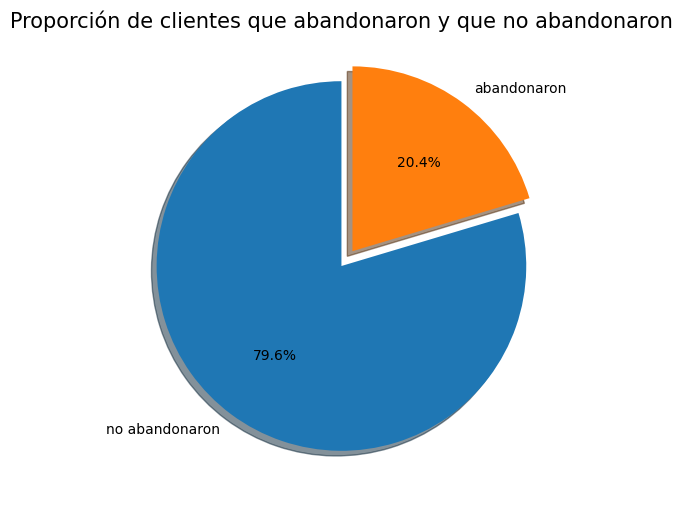

In [262]:
#comparo valores de cuantos de los clientes se fueron y cuantos no.
labels= ['no abandonaron', 'abandonaron']
y = [df2.salió[df2['salió']==0].count(), df2.salió[df2['salió']==1].count()]
explode = (0, 0.1)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.pie(y,labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax.set_title('Proporción de clientes que abandonaron y que no abandonaron', size= 15)
plt.show()

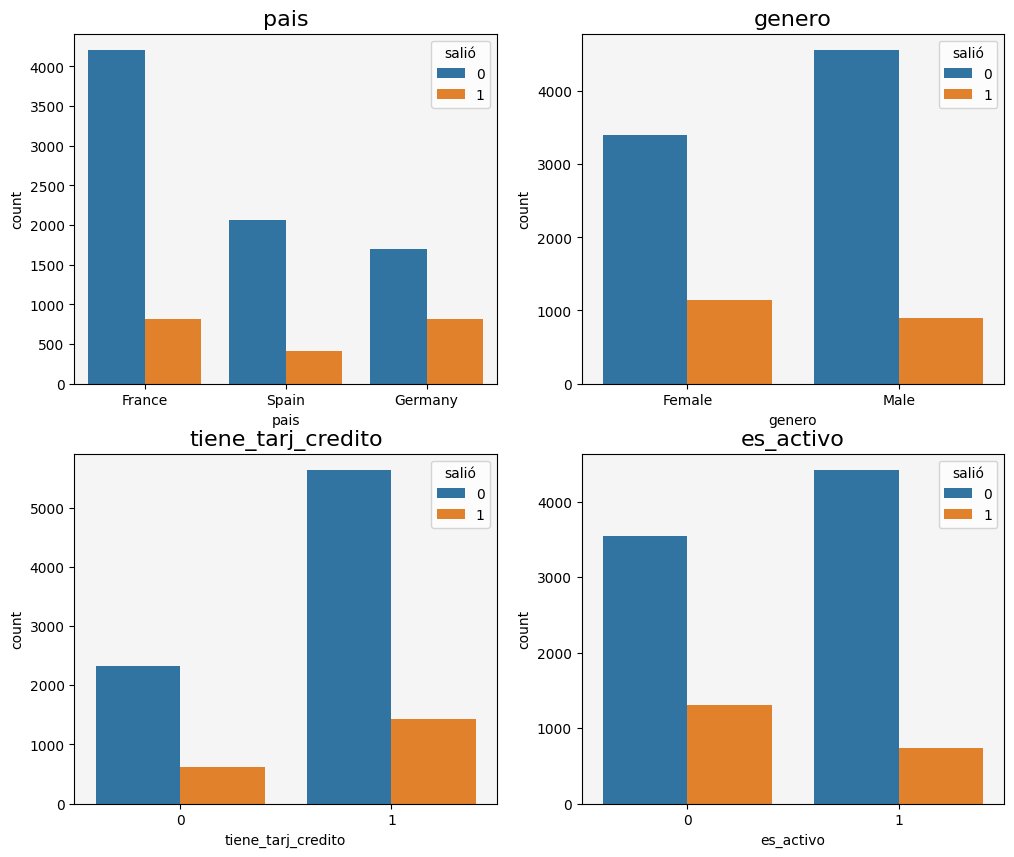

In [263]:
#se puede ver que hay variables continuas y variables categoricas
# primero vamos a examinar las variables categoricas en relación con los clientes que salieron
#('pais', 'genero', 'tiene_tarj_credito',	'es_activo')
fig = plt.figure(figsize= (12, 10))
list_cat = ['pais', 'genero', 'tiene_tarj_credito', 'es_activo']
c= 0
for i in list_cat:
    ax = fig.add_subplot(2,2,c+1)
    sns.countplot(data=df2, x=i, hue='salió', ax=ax)
    ax.set_facecolor('#F5F5F5')
    ax.set_title(i, size=16)
    c+=1
plt.show()

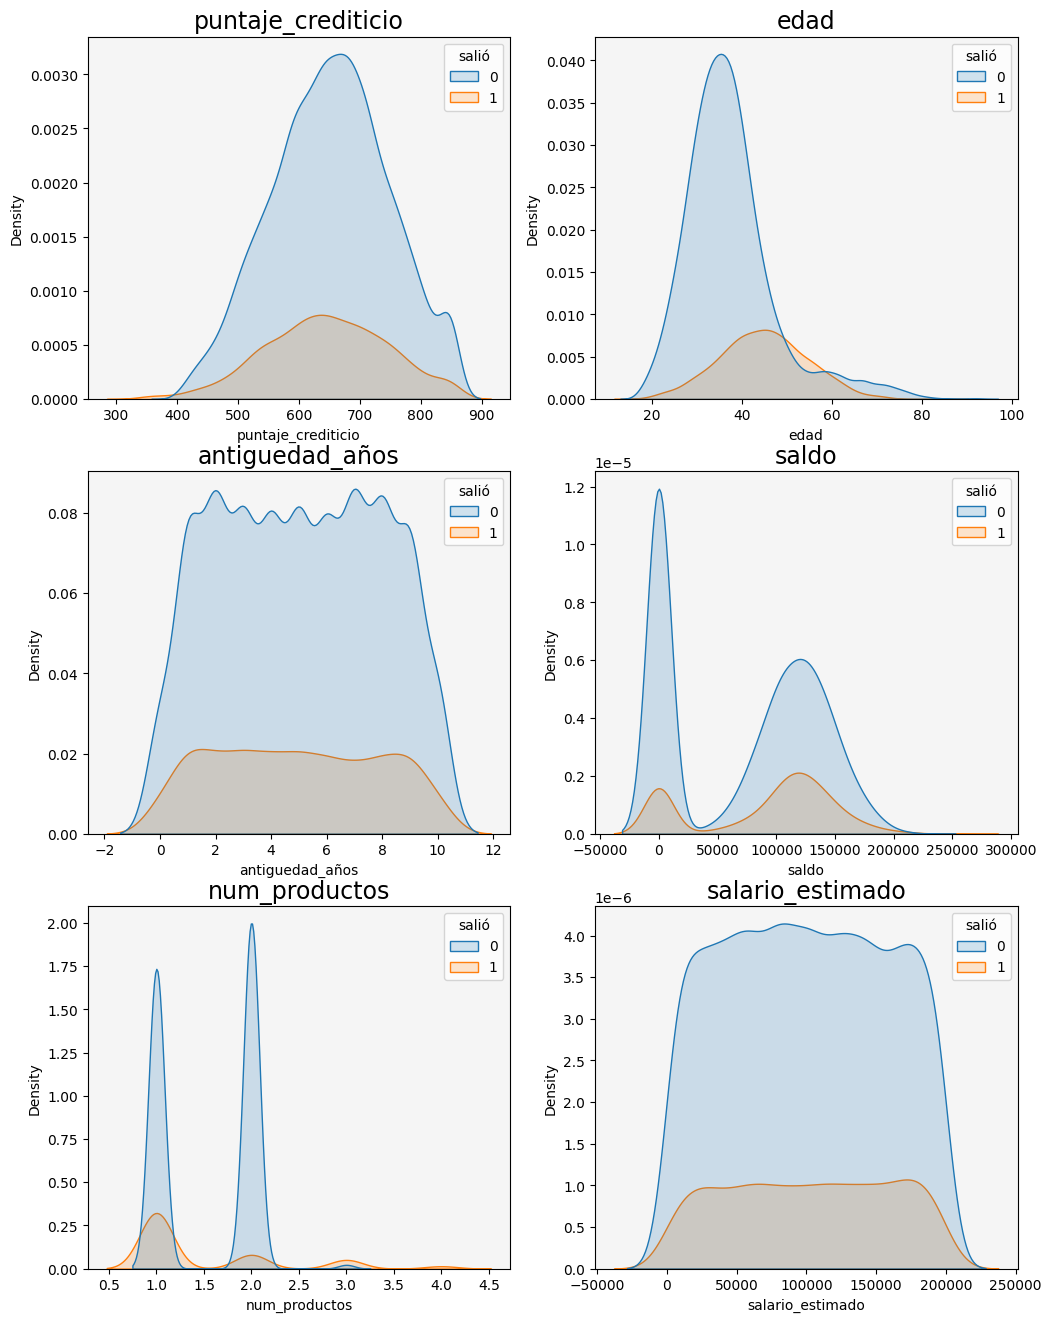

In [264]:
#examino las variables continuas discriminando por la columna 'salió'
#(puntaje_crediticio, edad, antiguedad_años, saldo, num_productos, salario_estimado)
fig = plt.figure(figsize= (12, 16))
list_con= ['puntaje_crediticio', 'edad', 'antiguedad_años', 'saldo', 'num_productos', 'salario_estimado']
c=0

for i in list_con:
    ax = fig.add_subplot(3,2,c+1)
    sns.kdeplot(data= df2, x=i, hue= 'salió', fill= True, alpha= 0.2, ax=ax)

    ax.set_facecolor('#F5F5F5')
    ax.set_title(i, size=17)

    c += 1
plt.show()

### **Codificar columnas categoricas**

In [265]:
#antes de proseguir creando el modelo de machine learning,
#primero voy a cambiar las columnas categoricas en texto a número('genero', 'pais')

In [266]:
df_cod= df2.copy()

In [267]:
from sklearn.preprocessing import LabelEncoder
#genero función para codificar las columnas categoricas ordinales
#('genero','pais')
def label_encoding(df, column):
    #hago una copia del df pasado como parametro
    df_copy = df.copy()

    #genero el LabelEncoder
    le = LabelEncoder()

    #aplico LabelEncoder a la columna pasada como parametro
    label_encoding= le.fit_transform(df_copy[column])

    #borro la columna pasada como parametro
    df_copy = df_copy.drop([column], axis=1)

    #genero otra columna con el mismo nombre de la columna pasada como parametro
    #que contenga los datos ya codificados
    df_copy[column]= label_encoding

    #retorno el dataframe ya codificado y el label encoder generado
    return df_copy, le

In [268]:
#aplico label encoder a las columnas categoricas ordinales
#(genero, pais)
df_cod, le_genero = label_encoding(df_cod, 'genero')
df_cod, le_pais = label_encoding(df_cod, 'pais')

In [269]:
df_cod.head()

,puntaje_crediticio,edad,antiguedad_años,saldo,num_productos,tiene_tarj_credito,es_activo,salario_estimado,salió,genero,pais
0,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,2
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,2


In [270]:
#Ahora voy a aplicarle OneHotEncoding a todas las columnas categoricas
#para ello voy a generar otra función que sea para aplicar OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df,column):
    #genero copia de df pasado como parametro
    df_copy= df.copy()

    #genero el OneHotEncoder
    ohe= OneHotEncoder(sparse=False)
    #Aplico el ohe a la columna pasada como parametro
    one_hot_encoding= ohe.fit_transform(df_copy[[column]])

    #creo las columnas ya codificadas y le agrego sufujo
    one_hot_encoding_df= pd.DataFrame(one_hot_encoding, dtype=int).add_prefix(column+'_')

    #uno las columnas al dataframe
    df_copy = df_copy.join(one_hot_encoding_df)

    #borro la columna original
    df_copy= df_copy.drop([column], axis=1)

    return df_copy, ohe

In [271]:
#le aplico la función a las columnas categoricas de entrada
#('pais','genero','tiene_tarj_credito','es_activo')

df_cod, ohe_pais = one_hot_encoding(df_cod, 'pais')
df_cod, ohe_genero = one_hot_encoding(df_cod, 'genero')
df_cod, ohe_tiene_tarj_credito = one_hot_encoding(df_cod, 'tiene_tarj_credito')
df_cod, ohe_es_activo = one_hot_encoding(df_cod, 'es_activo')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

In [272]:
df_cod.head()

,puntaje_crediticio,edad,antiguedad_años,saldo,num_productos,salario_estimado,salió,pais_0,pais_1,pais_2,genero_0,genero_1,tiene_tarj_credito_0,tiene_tarj_credito_1,es_activo_0,es_activo_1
0,619,42,2,0.00,1,101348.88,1,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,0,1,1,0,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,1,0,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,0,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,0,1,1,0,0,1,0,1


### **Normalizar columnas continuas**

In [273]:
df_norm = df_cod.copy()

In [274]:
list_con

['puntaje_crediticio',
 'edad',
 'antiguedad_años',
 'saldo',
 'num_productos',
 'salario_estimado']

In [275]:
#segundo, normalizo las columnas continuas para tener una mejor predicción.
#como nos esncontramos con algunos datos con outliers y no todos los datos
# estan balanceados, voy a usar RobustScaler para normalizar los datos continuos
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

#para normalizar las columnas, voy a usar list_con que genere anteriormente
df_norm[list_con] = scaler.fit_transform(df_norm[list_con])

df_norm.head()

,puntaje_crediticio,edad,antiguedad_años,saldo,num_productos,salario_estimado,salió,pais_0,pais_1,pais_2,genero_0,genero_1,tiene_tarj_credito_0,tiene_tarj_credito_1,es_activo_0,es_activo_1
0,-0.246269,0.416667,-0.75,-0.761480,0.0,0.011739,1,1,0,0,1,0,0,1,0,1
1,-0.328358,0.333333,-1.00,-0.104906,0.0,0.125512,0,0,0,1,1,0,1,0,0,1
2,-1.119403,0.416667,0.75,0.489346,2.0,0.139630,1,1,0,0,1,0,0,1,1,0
3,0.350746,0.166667,-1.00,-0.761480,1.0,-0.064717,0,1,0,0,1,0,1,0,1,0
4,1.477612,0.500000,-0.75,0.221806,0.0,-0.214561,0,0,0,1,1,0,0,1,0,1


### **Balanceo de datos con Sobre-muestreo (Oversampling)**

Ahora si, como un último paso antes de probar diferentes modelos de clasificación, debemos recordar que nuestros datos se encuentran desbalanceados en relación con nuestra columna target. Esto quiere decir que, al momento de crear nuestro modelo de clasificación, este nos va a dar resultados erróneos ya que le dimos para entrenar muchos datos donde las personas no abandonaron, y muy pocos sobre personas que si se fueron, por lo que vamos a tener en su mayoría, predicciones con falsos negativos (personas que no se fueron, pero en realidad sí).

Para ello, existen las técnicas de sobre-muestreo (oversampling) y sub-muestreo(undersampling), en este caso, voy a usar el sobre-muestreo para no perder datos que pueden ser de calidad para nuestra predicción.


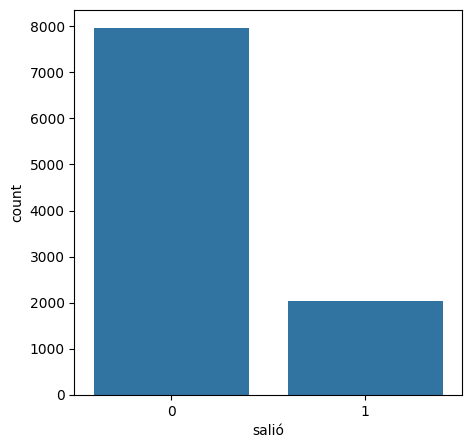

In [276]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x = 'salió', data = df_norm, ax=ax)
plt.show()

In [277]:
#primero separo los datos por clase:
datos_salieron = df_norm[df_norm['salió']==1]
datos_quedaron = df_norm[df_norm['salió']==0]

In [278]:
#sobre_muestreo con remplazo:
sobremuestreo_salieron = datos_salieron.sample(n=8000, replace=True, random_state=0)
sobremuestreo_salieron.shape

(8000, 16)

In [279]:
#concateno los dataframe datos_quedaron y sobremuestreo_salieron
df_bal = pd.concat([datos_quedaron, sobremuestreo_salieron])
df_bal.shape

(15963, 16)

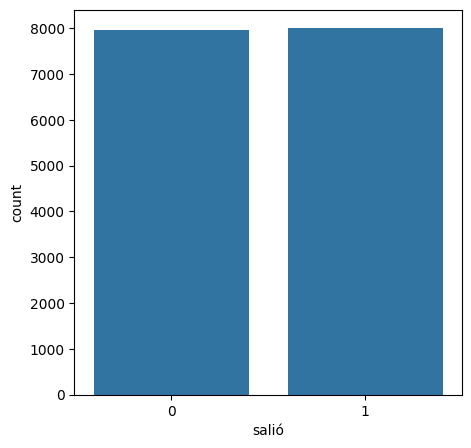

In [280]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x = 'salió', data = df_bal, ax=ax)
plt.show()

## **Entrenar modelo**

In [281]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#creo una función que me genere el y_hat del modelo y me muestre distintas metricas
def validation(df, model, X_test, y_test, name):
    y_hat = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_hat, normalize=True)
    f1 = f1_score(y_test, y_hat)
    precision =  precision_score(y_test, y_hat)
    recall= recall_score(y_test, y_hat)

    df_valid = pd.DataFrame({'model': [name.upper()], 'accuracy':[accuracy],
                             'f1_score':[f1], 'precision_score':[precision],
                             'recall_score':[recall]})
    df_valid = pd.concat([df, df_valid])

    return df_valid, y_hat, accuracy

In [282]:
#comienzo a crear el modelo
#para ello , primero creo las variables x e y
X = df_bal.drop('salió', axis=1).values
y = df_bal['salió'].values

In [283]:
#creo el campo de entrenamiento, 70% entrenamiento, 30% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### **Modelo K-Nearest Neigbours (KNN)**

In [284]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X_train, y_train)

### **DecisionTreeClassifier**

In [285]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=5)
dtc = dtc.fit(X_train, y_train)

### **Random Forest**

In [286]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5, criterion='entropy', max_depth=5, random_state=0)
rf = rf.fit(X_train, y_train)

### **Sopport Vector Machine (SVM)**

In [287]:
from sklearn import svm
svc = svm.SVC(kernel='poly')
svc = svc.fit(X_train, y_train)

### **Logistic Regression**

In [288]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='sag')
lr = lr.fit(X_train, y_train)

## **Validación de modelos**

In [289]:
df_model = pd.DataFrame(columns = ['model', 'accuracy', 'f1_score', 'precision_score',
                         'recall_score'])

In [290]:
#los evaluo con la función validation
df_model, y_hat_knn, accuracy_knn= validation(df_model, knn, X_test, y_test,'knn')
df_model, y_hat_dtc, accuracy_dtc = validation(df_model, dtc, X_test, y_test, 'dtc')
df_model, y_hat_rf, accuracy_rf = validation(df_model, rf, X_test, y_test, 'rf')
df_model, y_hat_svc, accuracy_svc = validation(df_model, svc, X_test, y_test, 'svc')
df_model, y_hat_lr, accuracy_lr = validation(df_model, lr, X_test, y_test, 'lr')

df_model

,model,accuracy,f1_score,precision_score,recall_score
0,KNN,0.809981,0.819731,0.783712,0.859219
0,DTC,0.776362,0.770320,0.796452,0.745847
0,RF,0.755272,0.750320,0.770341,0.731312
0,SVC,0.798914,0.797391,0.808102,0.786960
0,LR,0.710169,0.707296,0.718509,0.696429


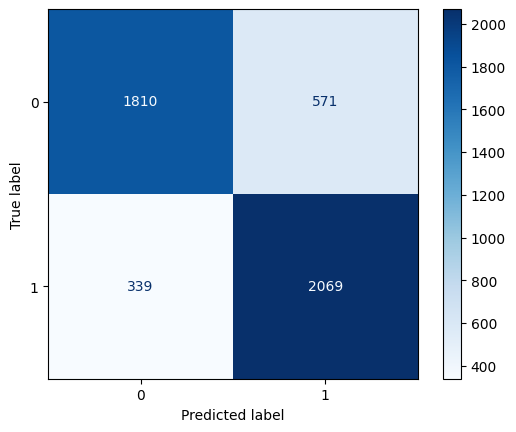

In [291]:
#me quedo con el mejor modelo y muestro metrica de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_hat_knn)

cmd = ConfusionMatrixDisplay(cm, display_labels= rf.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

## **Automatización de modelos**

In [292]:
from sklearn.model_selection import GridSearchCV

In [293]:
#Función para visualizar los datos de los modelos creados
def grid_model(model,name):
    print(f'\nMODELO {name.upper()}:')
    print(f'Mejor modelo:', model.best_estimator_)
    print(f'Mejores parametros:', model.best_params_)
    print(f'Mejor score:', model.best_score_)

In [294]:
parameters_knn= {"n_neighbors":[2,4,5,7,8,10]}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, parameters_knn, scoring = 'accuracy',cv=25)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=25, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 4, 5, 7, 8, 10]},
             scoring='accuracy')

In [295]:
parameters_rfc = {"criterion":["gini", "entropy"],
                  "n_estimators": [4,5,8,10,12,15],
                  "max_depth": [4,5,8,10,12,15,20]}
rfc = RandomForestClassifier()
grid_rfc= GridSearchCV(rfc, parameters_rfc, scoring='accuracy',cv=25)
grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=25, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 8, 10, 12, 15, 20],
                         'n_estimators': [4, 5, 8, 10, 12, 15]},
             scoring='accuracy')

In [296]:
parameters_dtc = {"criterion":["gini", "entropy"],
                  "max_depth": [4,5,8,10,12,15]}
dtc = DecisionTreeClassifier()
grid_dtc= GridSearchCV(dtc, parameters_dtc, scoring='accuracy',cv=25)
grid_dtc.fit(X_train, y_train)

GridSearchCV(cv=25, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 8, 10, 12, 15]},
             scoring='accuracy')

In [297]:
#en caso de querer automatizar aun mas el modelo, podemos agregar el siguiente
#parametro: "gamma" : [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5]
parameters_svc = {"C":[1,7,10,15,18,20],
                  "kernel":["linear", "poly", "rbf"]}
svc = svm.SVC()
grid_svc= GridSearchCV(svc, parameters_svc, scoring='accuracy', cv=5)
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 7, 10, 15, 18, 20],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [298]:
parameters_lr = {'solver':('lbfgs', 'sag')}
lr = LogisticRegression()
grid_lr= GridSearchCV(lr, parameters_lr, scoring='accuracy',cv=25)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=25, estimator=LogisticRegression(),
             param_grid={'solver': ('lbfgs', 'sag')}, scoring='accuracy')

## **Validación de los modelos automatizados**

In [299]:
#validando los modelos con la función grid_model(model,name):
grid_model(grid_knn, 'knn')
grid_model(grid_rfc, 'rfc')
grid_model(grid_dtc, 'dtc')
grid_model(grid_svc, 'svc')
grid_model(grid_lr, 'lr')


MODELO KNN:
Mejor modelo: KNeighborsClassifier(n_neighbors=2)
Mejores parametros: {'n_neighbors': 2}
Mejor score: 0.8746186334406758

MODELO RFC:
Mejor modelo: RandomForestClassifier(max_depth=20, n_estimators=10)
Mejores parametros: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 10}
Mejor score: 0.9343999357951867

MODELO DTC:
Mejor modelo: DecisionTreeClassifier(max_depth=15)
Mejores parametros: {'criterion': 'gini', 'max_depth': 15}
Mejor score: 0.8882218276301401

MODELO SVC:
Mejor modelo: SVC(C=20)
Mejores parametros: {'C': 20, 'kernel': 'rbf'}
Mejor score: 0.8126905922102787

MODELO LR:
Mejor modelo: LogisticRegression()
Mejores parametros: {'solver': 'lbfgs'}
Mejor score: 0.7027864888995897


In [300]:
df_model_grid = pd.DataFrame(columns = ['model', 'accuracy', 'f1_score', 'precision_score',
                         'recall_score'])

In [301]:
#validando los modelos con la función validation
df_model_grid, y_hat_grid_knn, accuracy_grid_knn = validation(df_model_grid, grid_knn, X_test, y_test, 'knn')
df_model_grid, y_hat_grid_rfc, accuracy_grid_rfc = validation(df_model_grid, grid_rfc, X_test, y_test, 'rfc')
df_model_grid, y_hat_grid_dtc, accuracy_grid_dtc = validation(df_model_grid, grid_dtc, X_test, y_test, 'dtc')
df_model_grid, y_hat_grid_svc, accuracy_grid_svc = validation(df_model_grid, grid_svc, X_test, y_test, 'svc')
df_model_grid, y_hat_grid_lr, accuracy_grid_lr = validation(df_model_grid, grid_lr, X_test, y_test, 'lr')

In [302]:
df_model_grid

,model,accuracy,f1_score,precision_score,recall_score
0,KNN,0.881186,0.881136,0.886507,0.875831
0,RFC,0.938818,0.940143,0.925211,0.955565
0,DTC,0.890374,0.896552,0.853018,0.944767
0,SVC,0.832115,0.835650,0.822866,0.848837
0,LR,0.710169,0.707296,0.718509,0.696429


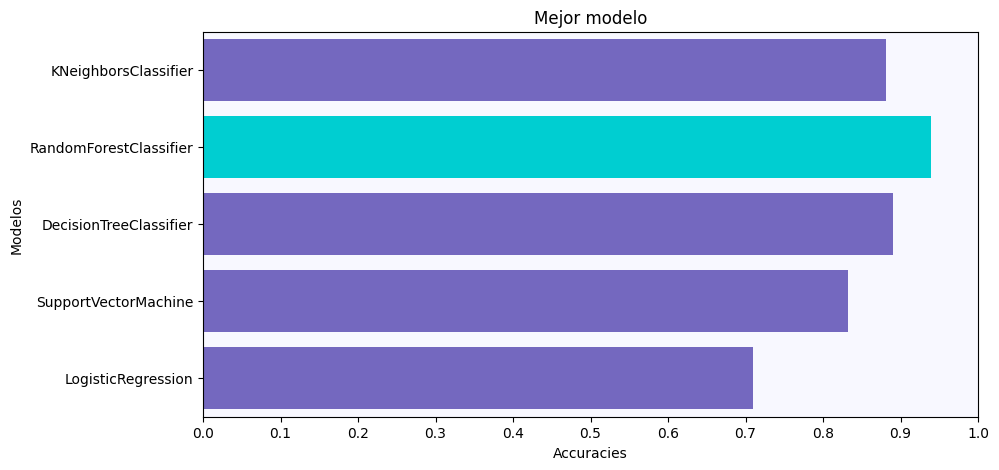

In [303]:
#Comparar los resultados de los modelos dependiendo de su accuracy con grafico de barra
#lista de los modelos generados
model_name= ['KNeighborsClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier',
             'SupportVectorMachine', 'LogisticRegression']

#accuracies de los modelos
accuracy = [accuracy_grid_knn, accuracy_grid_rfc, accuracy_grid_dtc,
              accuracy_grid_svc, accuracy_grid_lr]

fig = plt.figure(figsize= (10,5))
ax= sns.barplot(y=model_name, x=accuracy, color= '#6A5ACD')

#destaco la barra con mejor accuracy
color ='#00CED1'
accuracy_max = max(accuracy)
barra_max = accuracy.index(accuracy_max)
ax.patches[barra_max].set_facecolor(color)

#titulos
ax.set_title('Mejor modelo')
ax.set_ylabel('Modelos')
ax.set_xlabel('Accuracies')

ax.set_xticks(list(np.linspace(0,1,11)))

#fondo
ax.set_facecolor('#F8F8FF')
plt.show()

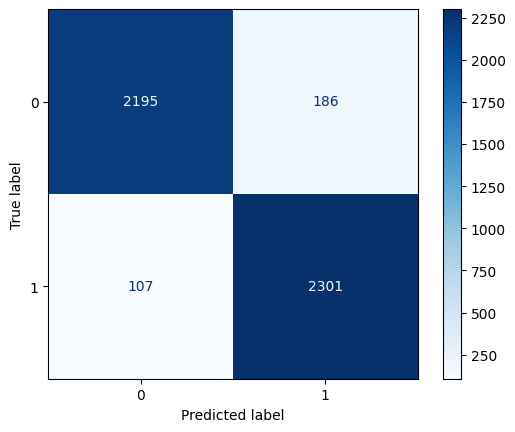

In [304]:
#confusion_matrix del mejor modelo
cm = confusion_matrix(y_test, y_hat_grid_rfc)

cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap=plt.cm.Blues)

plt.show()

## **Probar modelo**

In [305]:
df2.head(2)

,puntaje_crediticio,pais,genero,edad,antiguedad_años,saldo,num_productos,tiene_tarj_credito,es_activo,salario_estimado,salió
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [306]:
prueba = pd.DataFrame({'puntaje_crediticio': [600], 'pais': ['Spain'],
                       'genero':['Female'], 'edad':[30], 'antiguedad_años': [2],
                       'saldo': [73203.90],'num_productos': [2],
                       'tiene_tarj_credito':[1], 'es_activo':[1],
                       'salario_estimado': [101220.30]})
prueba

,puntaje_crediticio,pais,genero,edad,antiguedad_años,saldo,num_productos,tiene_tarj_credito,es_activo,salario_estimado
0,600,Spain,Female,30,2,73203.9,2,1,1,101220.3


In [307]:
#ahora debemos hacer el mismo proceso que hicimos en un principio
#primero creo una funcion para aplicar label_encoder a las columnas categoricas ordinales
def df_le(df,le,column):

    df_copy = df.copy()

    label_encoding= le.transform(df_copy[column])

    #borro la columna pasada como parametro
    df_copy = df_copy.drop([column], axis=1)

    #genero otra columna con el mismo nombre de la columna pasada como parametro
    #que contenga los datos ya codificados
    df_copy[column]= label_encoding

    #retorno el dataframe ya codificado y el label encoder generado

    return df_copy

In [308]:
df_prub= prueba.copy()

In [309]:
df_prub = df_le(df_prub, le_genero, 'genero')
df_prub = df_le(df_prub, le_pais, 'pais')

In [310]:
df_prub

,puntaje_crediticio,edad,antiguedad_años,saldo,num_productos,tiene_tarj_credito,es_activo,salario_estimado,genero,pais
0,600,30,2,73203.9,2,1,1,101220.3,0,2


In [311]:
#luego creo funcion para aplicar onehotencoder a todas las columnas categoricas
def df_ohe(df,ohe,column):
    df_copy = df.copy()

    ohe_transform = ohe.transform(df[[column]])

    #se crean las columnas con los valores de one_hot_encoder
    df_ohe = pd.DataFrame(ohe_transform, dtype= int).add_prefix(column+'_')

    #se unen las nuevas columnas al dataset original
    df_copy = df_copy.join(df_ohe)

    #y finalmente se elimina la columna vieja
    df_copy = df_copy.drop([column],axis=1)

    return df_copy

In [312]:
df_prub = df_ohe(df_prub,ohe_pais,'pais')
df_prub = df_ohe(df_prub,ohe_genero,'genero')
df_prub = df_ohe(df_prub,ohe_tiene_tarj_credito,'tiene_tarj_credito')
df_prub = df_ohe(df_prub,ohe_es_activo,'es_activo')

In [313]:
df_prub

,puntaje_crediticio,edad,antiguedad_años,saldo,num_productos,salario_estimado,pais_0,pais_1,pais_2,genero_0,genero_1,tiene_tarj_credito_0,tiene_tarj_credito_1,es_activo_0,es_activo_1
0,600,30,2,73203.9,2,101220.3,0,0,1,1,0,0,1,0,1


In [314]:
#ahora a normalizar las columnas continuas
df_prub[list_con] = scaler.transform(df_prub[list_con])

In [315]:
df_prub

,puntaje_crediticio,edad,antiguedad_años,saldo,num_productos,salario_estimado,pais_0,pais_1,pais_2,genero_0,genero_1,tiene_tarj_credito_0,tiene_tarj_credito_1,es_activo_0,es_activo_1
0,-0.38806,-0.583333,-0.75,-0.187981,1.0,0.010432,0,0,1,1,0,0,1,0,1


In [316]:
#hora de predecir nuestro df de prueba con el mejor modelo!
X_prueba = df_prub.values
y_hat_prueba= grid_rfc.predict(X_prueba)

if y_hat_prueba == [1]:
    print('Has abandonado')
else:
    print('No has abandonado')

No has abandonado
